# Model Aggregations
This model anlayses the best models of the subsequent folders and aims at creating a stacked generalization of them.

In [1]:
import sys

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
sys.path.insert(0, "..")
import problem

## Load data

In [3]:
X_train, y_train = problem.get_train_data("..")
X_test, y_test = problem.get_test_data("..")

In [4]:
path_tuning = "./tree_models/results_tuning"

## Pipe setup

In [5]:
# merge external data
merge_data = FunctionTransformer(problem._merge_external_data)

# date variables specifications
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = ["year", "month", "weekday", "hour"]

# additional data variables specifications
add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

# numerical variables in X
num_cols = ["temp", "prcp", "wspd", "latitude", "longitude"]

# categorical variables in X
categorical_cols = ["counter_name", "wdir"]

# binary variables in X
bin_cols = ["public_holiday", "school_holiday", "covid_lockdown"]

# create column transformer with all one hot encoders
preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("binary", "passthrough", bin_cols),
    ],
)

## Best models 

### Cat boost
This model is the model with the lowest bagged test for the ramp-test.

In [6]:
cat = CatBoostRegressor(
    depth=10,
    iterations=1000,
    rsm=0.25,
    sampling_frequency="PerTree",
    subsample=0.7,
    verbose=0,
)

In [7]:
cat_pipe = make_pipeline(
    merge_data,
    date_encoder,
    add_date_encoder,
    preprocessor,
    cat,
)

In [8]:
cv = problem.get_cv(X_train, y_train)
cat_scores = cross_val_score(
    cat_pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", cat_scores)
print(f"RMSE (all folds): {-cat_scores.mean():.3} ± {(-cat_scores).std():.3}")

RMSE:  [-0.88502794 -0.73909221 -0.67473167 -0.57098645 -0.69218892 -0.71632864
 -0.87157283 -0.72354255]
RMSE (all folds): 0.734 ± 0.0962


In [9]:
cat_pipe.fit(X_train, y_train)

y_pred_train = cat_pipe.predict(X_train)
y_pred_test = cat_pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.40
Test set, RMSE=0.44


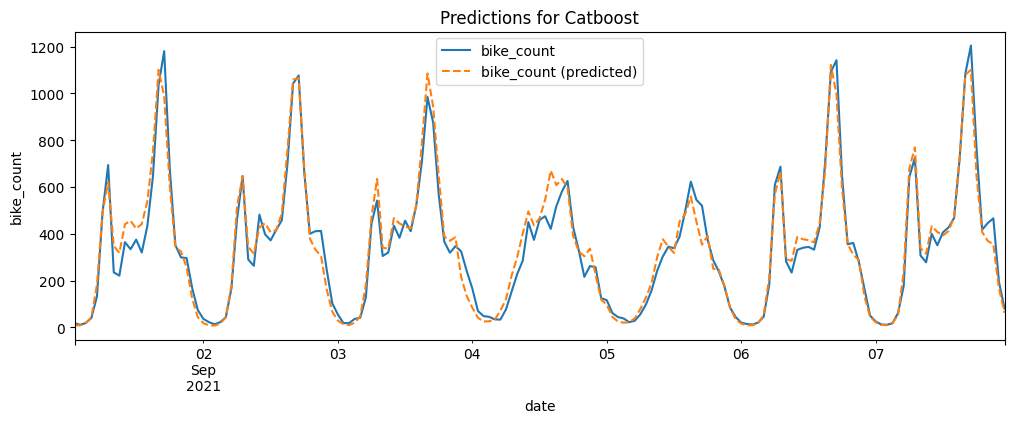

In [10]:
problem.week_plot(X_test, y_pred_test, y_test, "Catboost")

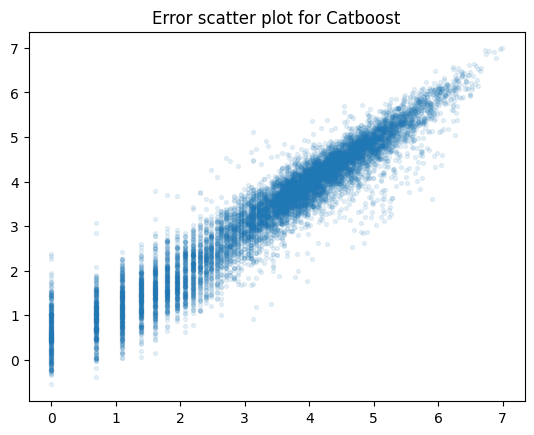

In [11]:
problem.error_plot(y_pred_test, y_test, "Catboost")

### XGB

In [12]:
xgb = XGBRegressor(
    colsample_bylevel=0.6,
    colsample_bynode=0.5,
    colsample_bytree=0.7,
    learning_rate=0.1,
    max_depth=10,
    n_estimators=300,
    subsample=0.8,
    n_jobs=6,
)

In [13]:
xgb_pipe = make_pipeline(
    merge_data,
    date_encoder,
    add_date_encoder,
    preprocessor,
    xgb,
)

In [14]:
cv = problem.get_cv(X_train, y_train)
scores_xgb = cross_val_score(
    xgb_pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores_xgb)
print(f"RMSE (all folds): {-scores_xgb.mean():.3} ± {(-scores_xgb).std():.3}")

RMSE:  [-0.87626969 -0.74045674 -0.67290624 -0.5633227  -0.68536668 -0.69310274
 -0.90762571 -0.71484481]
RMSE (all folds): 0.732 ± 0.105


In [15]:
xgb_pipe.fit(X_train, y_train)

y_pred_train = xgb_pipe.predict(X_train)
y_pred_test = xgb_pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.41
Test set, RMSE=0.44


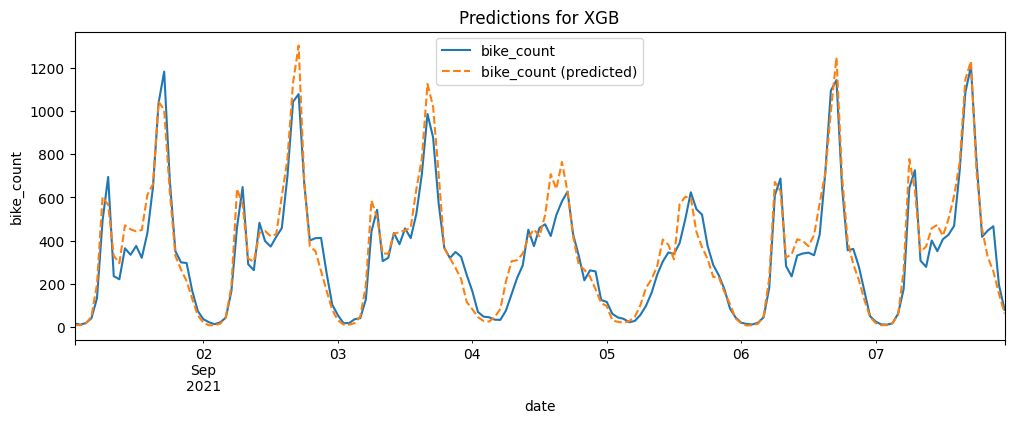

In [16]:
problem.week_plot(X_test, y_pred_test, y_test, "XGB")

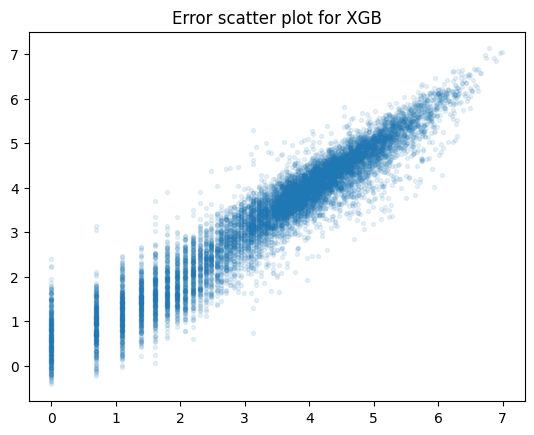

In [17]:
problem.error_plot(y_pred_test, y_test, "XGB")

### LightGBM

In [18]:
lgbm = LGBMRegressor(
    colsample_bytree=0.4,
    learning_rate=0.1,
    min_child_samples=20,
    n_estimators=1000,
    num_leaves=30,
    subsample=0.7,
    subsample_freq=1,
    n_jobs=6,
)

In [19]:
lgbm_pipe = make_pipeline(
    merge_data,
    date_encoder,
    add_date_encoder,
    preprocessor,
    lgbm,
)

In [20]:
cv = problem.get_cv(X_train, y_train)
lgbm_scores = cross_val_score(
    lgbm_pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", lgbm_scores)
print(f"RMSE (all folds): {-lgbm_scores.mean():.3} ± {(-lgbm_scores).std():.3}")

RMSE:  [-0.89513562 -0.75522537 -0.66727511 -0.56136569 -0.68404952 -0.71963592
 -0.85433285 -0.7461341 ]
RMSE (all folds): 0.735 ± 0.0987


In [21]:
lgbm_pipe.fit(X_train, y_train)

y_pred_train = lgbm_pipe.predict(X_train)
y_pred_test = lgbm_pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.44
Test set, RMSE=0.47


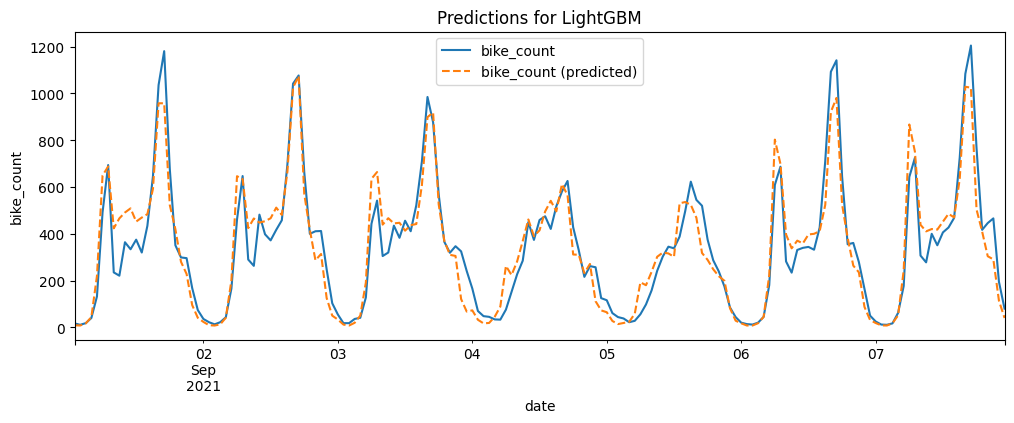

In [22]:
problem.week_plot(X_test, y_pred_test, y_test, "LightGBM")

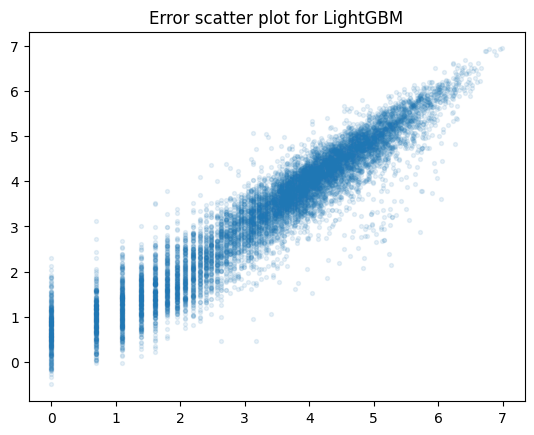

In [23]:
problem.error_plot(y_pred_test, y_test, "LightGBM")

## Voting Regressor

In [24]:
voting = VotingRegressor(
    [("cat", cat), ("xgb", xgb), ("lgbm", lgbm)], weights=[0.5, 0.25, 0.25]
)

voting_pipe = make_pipeline(
    merge_data,
    date_encoder,
    add_date_encoder,
    preprocessor,
    voting,
)

In [25]:
cv = problem.get_cv(X_train, y_train)
voting_scores = cross_val_score(
    voting_pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", voting_scores)
print(f"RMSE (all folds): {-voting_scores.mean():.3} ± {(-voting_scores).std():.3}")

RMSE:  [-0.87821813 -0.73337957 -0.6529508  -0.55501317 -0.68195204 -0.70447352
 -0.86904209 -0.7199456 ]
RMSE (all folds): 0.724 ± 0.1


In [26]:
voting_pipe.fit(X_train, y_train)

y_pred_train = voting_pipe.predict(X_train)
y_pred_test = voting_pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.40
Test set, RMSE=0.44


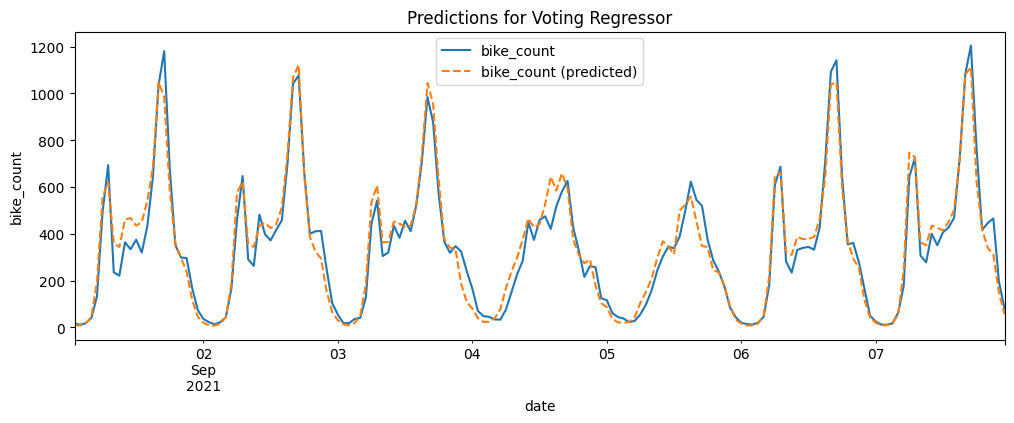

In [27]:
problem.week_plot(X_test, y_pred_test, y_test, "Voting Regressor")

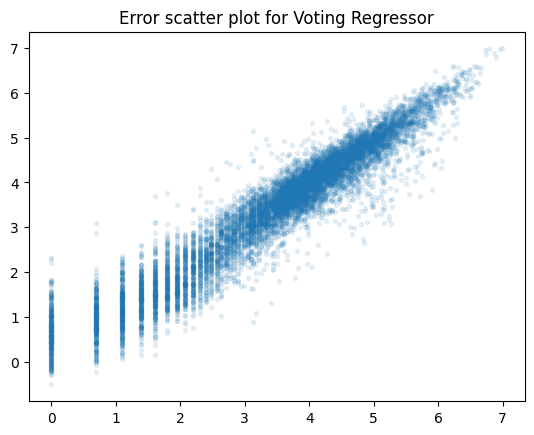

In [28]:
problem.error_plot(y_pred_test, y_test, "Voting Regressor")

## Run baseline model

In [29]:
baseline = make_pipeline(
    merge_data,
    date_encoder,
    add_date_encoder,
    preprocessor,
    Ridge(),
)

In [30]:
cv = problem.get_cv(X_train, y_train)
baseline_scores = cross_val_score(
    baseline, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", baseline_scores)
print(f"RMSE (all folds): {-baseline_scores.mean():.3} ± {(-baseline_scores).std():.3}")

RMSE:  [-0.92535491 -0.87259103 -0.82384129 -0.79961036 -0.84184009 -0.92274785
 -1.04340511 -0.88000302]
RMSE (all folds): 0.889 ± 0.0717


## Catboost with covid numbers
This model was the highest on the ramp leaderboard.

In [31]:
# merge external data
merge_cov_weather = FunctionTransformer(
    problem._merge_external_data, kw_args={"weather_only": False}
)

# numerical variables in X
num_cols_cov = ["temp", "prcp", "wspd", "latitude", "longitude", "daily_covid_cases"]

# create column transformer with all one hot encoders
preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("num", StandardScaler(), num_cols_cov),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("binary", "passthrough", bin_cols),
    ],
)

In [32]:
# catboost regressor with parameters obtained by gridsearch
regressor_cov = CatBoostRegressor(
    depth=10,
    iterations=1000,
    rsm=0.25,
    sampling_frequency="PerTree",
    subsample=0.7,
    verbose=0,
)

# define final pipeline
pipe_cov = make_pipeline(
    merge_cov_weather,
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor_cov,
)

In [33]:
cv = problem.get_cv(X_train, y_train)
cov_scores = cross_val_score(
    pipe_cov, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", cov_scores)
print(f"RMSE (all folds): {-cov_scores.mean():.3} ± {(-cov_scores).std():.3}")

RMSE:  [-0.88874217 -0.72116144 -0.71927149 -0.57097073 -0.70250322 -0.71077956
 -0.87513816 -0.67467427]
RMSE (all folds): 0.733 ± 0.0974


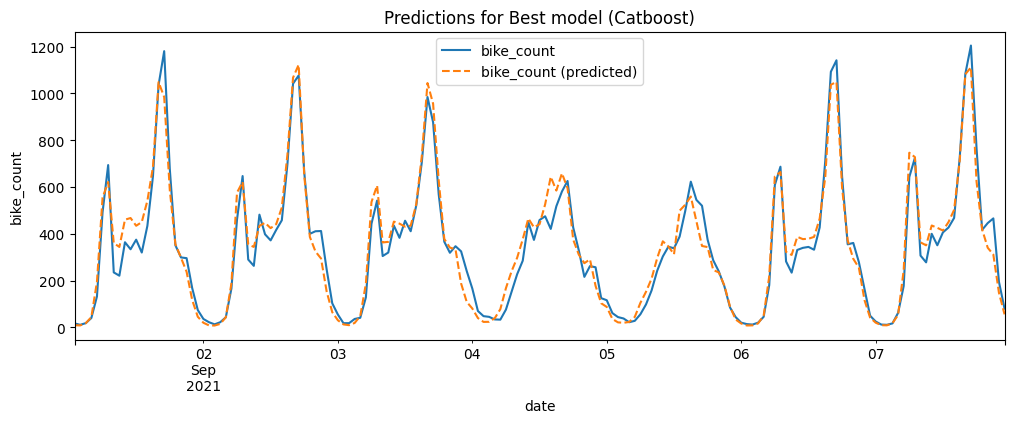

In [34]:
problem.week_plot(X_test, y_pred_test, y_test, "Best model (Catboost)")

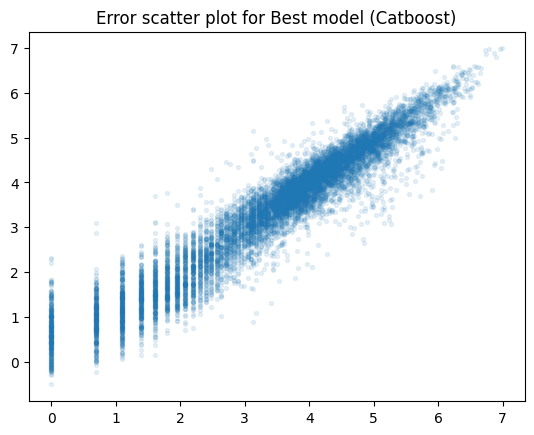

In [35]:
problem.error_plot(y_pred_test, y_test, "Best model (Catboost)")

## Plot all errors of the models

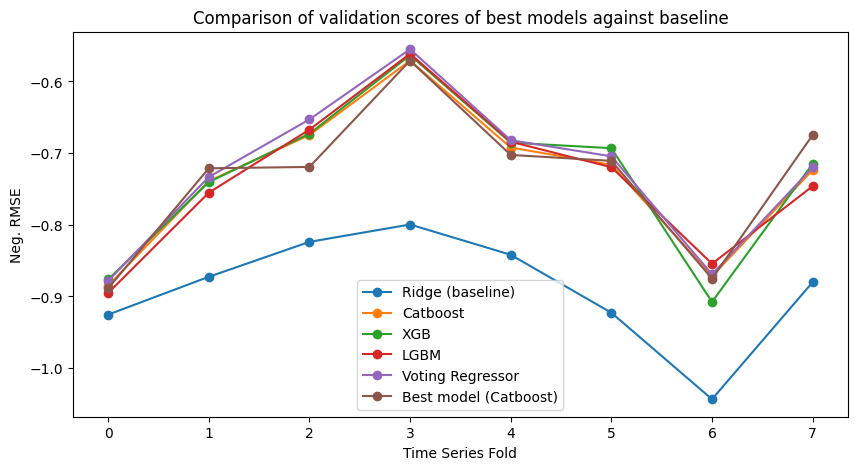

In [42]:
validation_errors = [
    baseline_scores,
    cat_scores,
    scores_xgb,
    lgbm_scores,
    voting_scores,
    cov_scores,
]
labels = [
    "Ridge (baseline)",
    "Catboost",
    "XGB",
    "LGBM",
    "Voting Regressor",
    "Best model (Catboost)",
]

plt.figure(figsize=(10, 5))
for errors, label in zip(validation_errors, labels):
    plt.plot(range(8), errors, "-o", label=label)

plt.xlabel("Time Series Fold")
plt.ylabel("Neg. RMSE")
plt.title("Comparison of validation scores of best models against baseline")
plt.legend();